# <font size = 5> Notes</font>

Part 5 of 5: Analysis

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: Oct 30, 2023

Notes:
- logging for auto-finding stuff... keep track of failure modes
- feature: keep track of K based on which species of K has the best signal
- write docstrings
- clean up code, improve speed? 

# <font size = 5>Setting up</font>

In [13]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import pandas as pd
from qutip import *
import scipy.constants
import pickle
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import lyse
import h5py
from pathlib import PureWindowsPath, PurePosixPath
from tqdm import tqdm
from joblib import Parallel, delayed
import numba

analysis_directory = '/Users/huanbui/Documents/GitHub/labscript-suite/userlib/analysislib/common/analysis_scripts'
sys.path.append(analysis_directory)

image_utils_directory = '/Users/huanbui/Documents/GitHub/labscript-suite/userlib/analysislib/common/image_utils'
sys.path.append(image_utils_directory)

from analysis_utility_functions import *
from analysis_ROI_finding_functions import *
from analysis_functions import *

In [14]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [417]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

# <font size = 5>Zeeman Effect Calculator</font>

In [452]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mjj == mj - 1) and (mii == mi + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mjj == mj + 1 and mii == mi - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mjj == mj - 2 and mii == mi + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mjj == mj + 2 and mii == mi - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [467]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None, labeling_mode='lf'):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))
   
    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
            mF = mj + mi
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H) 
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting, labeling states, and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        # labeling states depending on high or low field:
        gL = 1 - me/mn           # gyro magnetic factor of the orbital
        gS = 2.0023193043622     # electron spin g-factor
        gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
        if labeling_mode=='lf':
            # print out (F,mF) basis
            basisF = []
            possible_Fs = np.arange(abs(I-J), abs(I+J)+1, 1)
            if gI > 0:
                possible_Fs = np.flip(possible_Fs)
            for F in possible_Fs:
                gF = gJ*(F*(F+1) - I*(I+1) + J*(J+1))/(2*F*(F+1)) # without dividing a positive
                if gF > 0:
                    # if positive, then mF negative to positive:
                    mF = np.linspace(-F, F, int(2*F+1))
                    for mf in mF:
                        basisF.append([F,mf])
                else:
                    # if negative, then mF positive to negative:
                    mF = np.flip(np.linspace(-F, F, int(2*F+1)))
                    for mf in mF:
                        basisF.append([F,mf])
            basisF = np.array(basisF)
            print('(F, mF) basis, low to high in energy: ')
            print(basisF)
        elif labeling_mode=='hf':
            # rank the mj mi basis based on the value of gJ * mJ + gI*mI:
            vals = []
            for b in basis:
                B_hf = 10*Ahf*hbar*2*np.pi/(muB *1e-4)
                vals.append(  Ahf*b[0]*b[1] + (gJ*b[0] + gI*b[1])*B_hf*1e-4*muB/(hbar*2*np.pi)    )
            sort_vals = np.argsort(np.array(vals))
            sorted_mJmI_basis = np.array(basis)
            sorted_mJmI_basis = sorted_mJmI_basis[sort_vals]
            print('(mJ, mI) basis, low to high in energy: ')
            print(sorted_mJmI_basis)
        elif labeling_mode == 'none':
            print('No state labeling')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        print('Frequencies (MHz)')
        print(freqs)
        print('')
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might be due to bad guesses!')
    return 

(F, mF) basis, low to high in energy: 
[[ 4.5 -4.5]
 [ 4.5 -3.5]
 [ 4.5 -2.5]
 [ 4.5 -1.5]
 [ 4.5 -0.5]
 [ 4.5  0.5]
 [ 4.5  1.5]
 [ 4.5  2.5]
 [ 4.5  3.5]
 [ 4.5  4.5]
 [ 3.5  3.5]
 [ 3.5  2.5]
 [ 3.5  1.5]
 [ 3.5  0.5]
 [ 3.5 -0.5]
 [ 3.5 -1.5]
 [ 3.5 -2.5]
 [ 3.5 -3.5]]


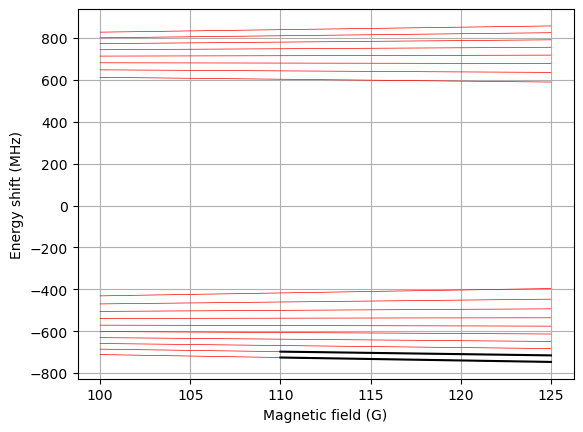

Frequencies (MHz)
[-725.70789378 -697.55786486 -668.33940302 -637.92060859 -606.13997958
 -572.79618096 -537.63276199 -500.31439105 -460.38802728 -417.21540222
  603.44364524  643.31566445  680.57969083  715.68876524  748.97821931
  780.70450375  811.06895363  840.2330709 ]

Frequency spacings (MHz), from low to high in state energy, at 110.0 G:
28.1500
29.2185
30.4188
31.7806
33.3438
35.1634
37.3184
39.9264
43.1726
1020.6590
39.8720
37.2640
35.1091
33.2895
31.7263
30.3644
29.1641
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 110.0 G:
-1.402
-1.193
-0.969
-0.728
-0.467
-0.180
0.139
0.498
0.912
1.402
-0.910
-0.497
-0.138
0.180
0.466
0.727
0.968
1.191
 
Field sensitivity of splitting, df21 by dB:
0.2093 MHz per G
 
Closest B field (G): 105.00
Splitting Error (MHz): -0.00033


In [529]:
# Zeeman calculator cell
B_start, B_end, num_B = 100, 125, 5000
B_main = 110.0
find_B_at_resonance_MHz = 27.095

# Careful what you type in here!
Ahf, Bhf = K40Ahf_s12, K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I, gI = K40I, K40gI

from_to = [1,2]

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = from_to, plot_range = None, 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = from_to,
                            search_mode = True, splitting = find_B_at_resonance_MHz, splitting_between_states = from_to,
                            labeling_mode='lf')

# <font size = 5>Landau-Zener transition (linear sweep)</font>

In [ ]:
# LZ solver
def LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    a = destroy(2)

    H0 = - (delta0/2.0) * sz - (omegaR/2.0) * sx
    H1 = - ddelta_dt/2.0 * sz        

    # collapse operators
    c_op_list = []

    # evolve and calculate expectation values. Method: Cython string-based
    # want to return expectation value of aTa = [[0,0],[0,1]] = P_excited
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a], {})  

    return output.expect[0]

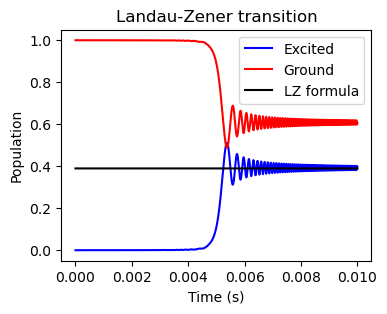

In [ ]:
# calculate
sweep_time   = 10e-3              # sweep time in secs
sweep_span   = 50e3 * 2 * np.pi   # sweep span in Hz * 2pi, make sure this is >> omegaR for good LZ
sweep_center = 0 * 2 * np.pi # sweep center in Hz * 2pi
ddelta_dt    = sweep_span/sweep_time   # sweep rate in Hz/s * 2pi
delta0       = -sweep_span/2   # initial detuning in Hz * 2pi
omegaR       = 0.5e3 * 2 * np.pi   # Rabi frequency in Hz * 2pi
psi0         = basis(2,0)      # initial state
tlist        = np.linspace(0, sweep_time, 10000)
p_ex         = LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist)

# display results
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.plot(tlist, 1 - np.exp(-np.pi * omegaR **2 / (2 * ddelta_dt)) * np.ones(np.shape(tlist)), 'k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Population')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited", "Ground", "LZ formula"), loc=0)
plt.show()

# <font size = 5>Rabi Solution for Two-Level System</font>

In [441]:
def _P2_Rabi(omega, tau, omegaR, omega0, offset):    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau / 2)**2 + offset

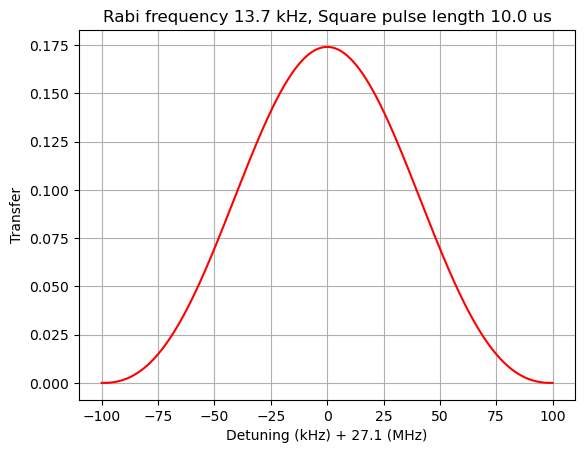

In [450]:
detunings = np.arange(-100e3,100e3,0.001e3)
f0 = 27.1e6
tau = 10e-6
f_Rabi = 13.7e3
offset = 0
P2 = _P2_Rabi(detunings+f0, tau , f_Rabi, f0, offset)
plt.plot(detunings*1e-3, P2, color = 'red')
plt.xlabel(f'Detuning (kHz) + {f0*1e-6:.1f} (MHz)')
plt.ylabel('Transfer')
plt.title(f'Rabi frequency {omegaR*1e-3:.1f} kHz, Square pulse length {tau*1e6:.1f} us')
plt.grid()
plt.show()

# <font size = 5>PA analysis</font>

In [85]:
# helper functions
def round_frequency(frequency_THz, precision):
    """
    Take a THz frequency and round it to a given precision in Hz. Written for use with wavemeter.
    Example:
    >> test_freq_THz = 123.456789
    >> precision = 3e8
    >> print(round_frequency(test_freq_THz, precision))
    >> 123.4569
    """
    frequency = frequency_THz * 1e12
    rounded_frequency = round(frequency / precision) * precision
    return rounded_frequency / 1e12

def raw_to_averages_and_stdev(x_var, y_var):
    result_x_var = np.unique(x_var)
    y_var_averages = np.empty(result_x_var.shape)
    y_var_stdevs   = np.empty(result_x_var.shape)

    for i, x in enumerate(result_x_var):
        y_var_averages[i] = np.mean(y_var[x_var == x])
        y_var_stdevs[i]   = np.std(y_var[x_var == x])
    return result_x_var, y_var_averages, y_var_stdevs

def sum_of_lorentzians(xdata, *params):
    n = (len(params) - 1) // 3
    offset = params[-1]
    ydata = xdata*0
    for i in range(n):
        center = params[i]
        width = params[i + n]
        amplitude = params[i + 2*n]
        ydata += amplitude * width / ( (xdata-center)**2 + (width/2)**2)
    return ydata + offset

In [ ]:
# get data folder path
folder_path = filedialog.askdirectory()
filepaths = sorted(glob.glob(folder_path + '/*.pkl'))
df = pickle.load(open(filepaths[0], 'rb'))
for filepath in filepaths:
    df = df.append(pickle.load(open(filepath, 'rb')))

In [ ]:
# get PA data 
upleg_frequencies_THz     = df['zcam_triple_analysis']['UPLEG_FREQUENCY'] - 372 # THz
upleg_frequencies_GHz     = round_frequency(upleg_frequencies_THz, precision = 4e6) * 1e3 # GHz
K_m92_NcntLarge_raw       = df['zcam_triple_analysis']['K2_NcntLarge']
K_m92_transferLarge_raw   = df['zcam_triple_analysis']['K2_transferLarge']
K_m72_NcntLarge_raw       = df['zcam_triple_analysis']['K1_NcntLarge']
K_m72_transferLarge_raw   = df['zcam_triple_analysis']['K1_transferLarge']
Na_NcntLarge_raw          = df['zcam_triple_analysis']['Na_NcntLarge']

upleg_frequencies_GHz_unique, K_m92_NcntLarge_avg, K_m92_NcntLarge_std         = raw_to_averages_and_stdev(upleg_frequencies_GHz, K_m92_NcntLarge_raw)
upleg_frequencies_GHz_unique, K_m92_transferLarge_avg, K_m92_transferLarge_std = raw_to_averages_and_stdev(upleg_frequencies_GHz, K_m92_transferLarge_raw)
upleg_frequencies_GHz_unique, K_m72_NcntLarge_avg, K_m72_NcntLarge_std         = raw_to_averages_and_stdev(upleg_frequencies_GHz, K_m72_NcntLarge_raw)
upleg_frequencies_GHz_unique, Na_NcntLarge_avg, Na_NcntLarge_std               = raw_to_averages_and_stdev(upleg_frequencies_GHz, Na_NcntLarge_raw)

In [ ]:
# guess and fit PA lines
center_guesses             = np.array([553.72, 553.84, 553.95, 554.14, 554.19, 554.23, 554.28])
width_guesses              = np.array([40,     40,     40,     40,     40,     40,     40]) * 1e-3  
amplitude_guesses_transfer = np.array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])
offset_guesses_transfer    = np.array([0.4])
amplitude_guesses_counts   = np.array([-200, -200, -200, -200, -200, -200, -200])
offset_guesses_counts      = np.array([400])
# puting guesses together
initial_guess_transfer = np.concatenate((center_guesses, width_guesses, amplitude_guesses_transfer, offset_guesses_transfer))
initial_guess_counts = np.concatenate((center_guesses, width_guesses, amplitude_guesses_counts, offset_guesses_counts))
params_PA_transfer, covariance_PA_transfer = scipy.optimize.curve_fit(sum_of_lorentzians, upleg_frequencies_GHz_unique, K_m92_transferLarge_avg, 
                                                              p0    = initial_guess_transfer)
params_PA_counts, covariance_PA_counts     = scipy.optimize.curve_fit(sum_of_lorentzians, upleg_frequencies_GHz_unique, K_m92_NcntLarge_avg, 
                                                              p0    = initial_guess_counts)
freqs = np.linspace(min(upleg_frequencies_GHz_unique), max(upleg_frequencies_GHz_unique), 1000)
PA_transfer_lines = sum_of_lorentzians(freqs, *params_PA_transfer)
PA_counts_lines   = sum_of_lorentzians(freqs, *params_PA_counts)

In [ ]:
# plot K m92 counts and transfers
fig_Km92, ax_Km92 = plt.subplots(2,1,figsize = (10,7.5))

line_labels = [2,3,4,6,7,8,9]
transferLarge_PA_lines_from_fit = params_PA_transfer[0:7]
ax_Km92[0].errorbar(upleg_frequencies_GHz_unique, K_m92_transferLarge_avg, yerr = K_m92_transferLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth=0.5)
ax_Km92[0].plot(freqs, PA_transfer_lines, color = 'black', linewidth = 1.0)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km92[0].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km92[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 0.375, 
                    rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km92[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 0.125, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')    
ax_Km92[0].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km92[0].set_ylabel('K mF = -9/2 fraction', fontsize = 12)
ax_Km92[0].tick_params(axis='both', which='major', labelsize=12)
ax_Km92[0].tick_params(axis='both', which='minor', labelsize=12)
ax_Km92[0].grid()

# counts_PA_lines_from_fit = params_PA_counts[0:7]
ax_Km92[1].errorbar(upleg_frequencies_GHz_unique, K_m92_NcntLarge_avg, yerr = K_m92_NcntLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth = 0.5)
ax_Km92[1].plot(freqs, PA_counts_lines, color = 'black', linewidth = 1.0)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km92[1].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km92[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 330, 
                    rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km92[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 85, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')
ax_Km92[1].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km92[1].set_ylabel('K mF = -9/2 count (arb.)', fontsize = 12)
ax_Km92[1].tick_params(axis='both', which='major', labelsize=12)
ax_Km92[1].tick_params(axis='both', which='minor', labelsize=12)
ax_Km92[1].grid()

fig_Km92.suptitle('PA spectrum of NaK Feshbach molecules at 85.7 G ($E_b$~80 kHz). Horizontal polarization, ~700 mW, 10 $\mu$s pulse')
fig_Km92.tight_layout()
fig_Km92.show()

In [ ]:
# plot K m72 and Na counts and transfers
fig_Km72_Na, ax_Km72_Na = plt.subplots(2,1,figsize = (10,7.5))
ax_Km72_Na[0].errorbar(upleg_frequencies_GHz_unique, K_m72_NcntLarge_avg, yerr = K_m72_NcntLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth=0.5)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km72_Na[0].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km72_Na[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 700, 
                    rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km72_Na[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 400, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')
ax_Km72_Na[0].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km72_Na[0].set_ylabel('K -7/2 count (arb.)', fontsize = 12)
ax_Km72_Na[0].tick_params(axis='both', which='major', labelsize=12)
ax_Km72_Na[0].tick_params(axis='both', which='minor', labelsize=12)
ax_Km72_Na[0].grid()

ax_Km72_Na[1].errorbar(upleg_frequencies_GHz_unique, Na_NcntLarge_avg, yerr = Na_NcntLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth=0.5)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km72_Na[1].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km72_Na[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 1420, 
                rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km72_Na[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 500, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')
ax_Km72_Na[1].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km72_Na[1].set_ylabel('Na (1,1) count (arb.)', fontsize = 12)
ax_Km72_Na[1].tick_params(axis='both', which='major', labelsize=12)
ax_Km72_Na[1].tick_params(axis='both', which='minor', labelsize=12)
ax_Km72_Na[1].grid()

fig_Km72_Na.suptitle('PA spectrum of NaK Feshbach molecules at 85.7 G ($E_b$~80 kHz). Horizontal polarization, ~700 mW, 10 $\mu$s pulse')
fig_Km72_Na.tight_layout()
fig_Km72_Na.show()

# <font size = 5>Modeling the analysis of absorption images</font>

## <font size = 3>Helper functions</font>

In [169]:
# helper functions
def generate_atom_gaussian_OD(max_OD, xsize, ysize, width_x, width_y):
    n2d = np.zeros([ysize, xsize])
    for x in range(xsize):
        for y in range(ysize):
            n2d[y,x] = (1/width_x)*(1/width_y)*(1/np.sqrt(2*np.pi))**2*np.exp(-(x - xsize/2)**2/(2*width_x**2) - (y - ysize/2)**2/(2*width_y**2))
    # normalize so that max is max_OD:
    n2d = max_OD*n2d / np.max(n2d)
    return n2d

def generate_without_atom_light(xsize, ysize, light_level):
    woa_light = light_level * np.ones([ysize, xsize])
    return woa_light

def generate_dark_light(xsize, ysize, light_level):
    dark_light = light_level * np.ones([ysize, xsize])
    return dark_light

def generate_with_atom_from_true_OD(woa, atom_OD, dark):
    wa = np.exp(-atom_OD)*(woa - dark) + dark
    return wa

def generate_shot_noise(shot):
    shot = np.array(shot)
    new_shot = 0*shot
    for i in range(shot.shape[0]):
        for j in range(shot.shape[1]):
            new_shot[i,j] = np.random.poisson(lam = shot[i,j])
    return new_shot

## <font size = 3>Given OD(x,y), find the effect of box sizes and max OD on atom counting using the binned vs unbinned techniques</font>

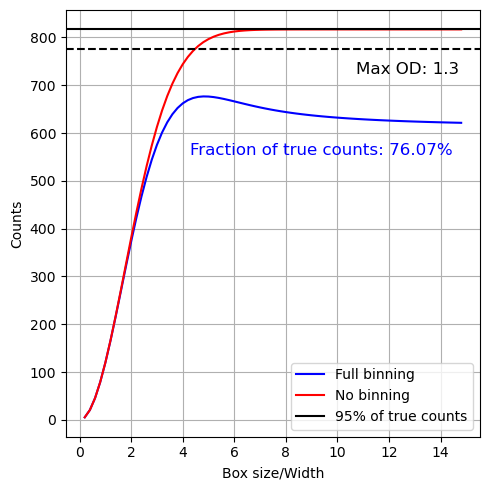

In [170]:
# For a fixed OD. What box size do we need to capture 95% of the atoms? Fully binned vs unbinned case.
width, light_level_woa, light_level_dark, max_OD = 10, 1000, 100, 1.3
size = np.arange(2,150,2)
unbinned_ODs = []
binned_ODs = []
raw_counts = sum(sum(generate_atom_gaussian_OD(max_OD = max_OD, xsize = np.max(size), ysize = np.max(size), width_x = width, width_y = width)))

for s in size:
    true_OD = generate_atom_gaussian_OD(max_OD = max_OD, xsize = s, ysize = s, width_x = width, width_y = width)
    without_atoms = generate_without_atom_light(xsize=s, ysize = s, light_level=light_level_woa)
    dark = generate_dark_light(xsize=s, ysize = s, light_level=light_level_dark)
    with_atoms = generate_with_atom_from_true_OD(without_atoms, true_OD, dark)
    
    # calculate raw_counts from summing the absorption, then take -log:
    absorption_fraction = (with_atoms - dark) / (without_atoms - dark)
    unbinned_ODs.append(sum(sum(-np.log(absorption_fraction))))

    average_absorption_fraction = sum(sum(absorption_fraction)) / (s*s) 
    binned_ODs.append(-np.log( average_absorption_fraction ) * s*s)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(size/width, binned_ODs, color = 'blue', label = 'Full binning')
ax.plot(size/width, unbinned_ODs, color = 'red', label = 'No binning')
ax.axhline(y = raw_counts, color = 'black', label = '95% of true counts')
ax.axhline(y = 0.95 * raw_counts, linestyle = 'dashed', color = 'black')
ax.text(x=0.3, y = binned_ODs[-1] / unbinned_ODs[-1]-0.1, transform = ax.transAxes , 
           s = f'Fraction of true counts: {100 * binned_ODs[-1] / unbinned_ODs[-1]:.2f}%',
           fontsize = 12, color = 'blue')
ax.text(x=0.7, y = 0.85, transform = ax.transAxes , 
           s = f'Max OD: {max_OD}',
           fontsize = 12, color = 'black')
ax.legend()
ax.set_xlabel('Box size/Width')
ax.set_ylabel('Counts')
ax.grid()
fig.tight_layout()
plt.show()

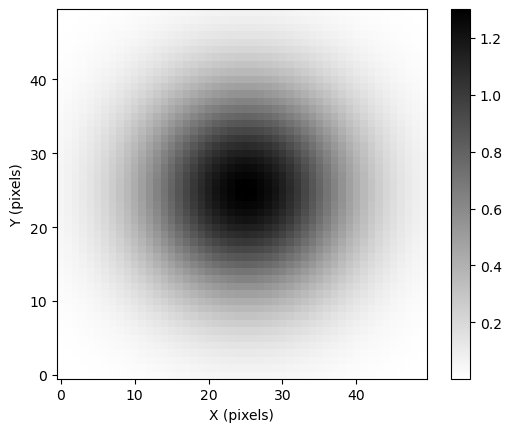

In [171]:
true_OD = generate_atom_gaussian_OD(max_OD = max_OD, xsize = 50, ysize = 50, width_x = width, width_y = width)
plt.imshow(true_OD, cmap = 'gray_r', origin='lower')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.colorbar()
plt.show()

In [172]:
# The fractional count depends on Max OD. How does this landscape look like as a function of Max OD and box size?
width, light_level_woa, light_level_dark = 10, 1000, 100
size = np.arange(20,150,2)
max_OD = np.linspace(0.2,3.0,50)
smallest_95_box_size = np.array([])
fraction_of_true_counts = np.zeros((len(size), len(max_OD)))
for j in range(len(max_OD)):
    search_box_size = True
    for i in range(len(size)):
        true_OD = generate_atom_gaussian_OD(max_OD = max_OD[j], xsize = size[i], ysize = size[i], width_x = width, width_y = width)
        without_atoms = generate_without_atom_light(xsize=size[i], ysize = size[i], light_level=light_level_woa)
        dark = generate_dark_light(xsize=size[i], ysize = size[i], light_level=light_level_dark)
        with_atoms = generate_with_atom_from_true_OD(without_atoms, true_OD, dark)

        true_counts = sum(sum(generate_atom_gaussian_OD(max_OD = max_OD[j], 
                                                        xsize = width*5, 
                                                        ysize = width*5, 
                                                        width_x = width, 
                                                        width_y = width)))
        
        # calculate raw_counts from summing the absorption, then take -log:
        absorption_fraction = (with_atoms - dark) / (without_atoms - dark)
        average_absorption_fraction = sum(sum(absorption_fraction)) / (size[i]*size[i]) 
        binned_OD = -np.log( average_absorption_fraction ) * size[i]*size[i]
        fraction_of_true_counts[i,j] = binned_OD / true_counts

        # what is the smallest box size for which the unbinned_OD counts >= 95% true counts?
        unbinned_OD = sum(sum(-np.log(absorption_fraction)))
        
        if unbinned_OD >= 0.95 * true_counts and search_box_size:
            smallest_95_box_size = np.append(smallest_95_box_size, size[i])
            search_box_size = False

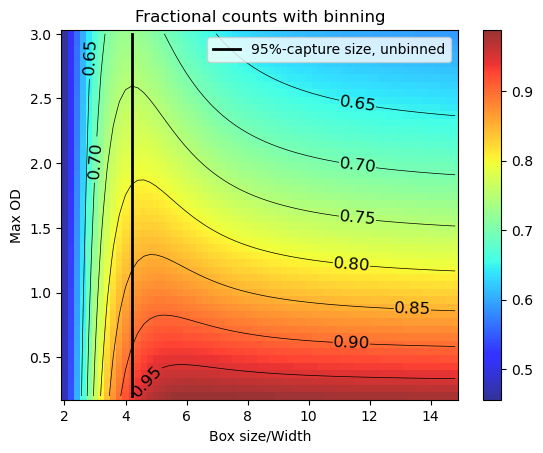

In [173]:
# plotting the landscape
fig, ax = plt.subplots()
contours = ax.contour(size / width, max_OD, fraction_of_true_counts.T, 
                      levels=np.arange(0.65,1.0,0.05), 
                      linewidths = 0.5 , 
                      colors='k',
                      interpolation='none', 
                      label = 'Fraction of true count, binned')
im = ax.pcolormesh(size / width, max_OD, fraction_of_true_counts.T, cmap = 'jet', alpha = 0.8)
ax.clabel(contours, inline=1, fontsize=12)
ax.plot(smallest_95_box_size/width, max_OD, color = 'black', linewidth = 2, label = '95%-capture size, unbinned')
ax.set_xlabel('Box size/Width')
ax.set_ylabel('Max OD')
ax.set_title('Fractional counts with binning')
ax.legend()
PCM = ax.get_children()[2] 
plt.colorbar(im, ax=ax) 
plt.show()

## <font size = 3>Given OD(x,y), find the effect of binning</font>

In [174]:
# The fractional count depends on Max OD. How does this landscape look like as a function of Max OD and box size?
size, width, light_level_woa, light_level_dark = 2**8, 10, 1000, 100
big_pixel_size = np.power(2, np.arange(0,8+1,1))
max_OD = np.linspace(0.2,3.0,len(big_pixel_size))
smallest_95_box_size = np.array([])
fraction_of_true_counts = np.zeros((len(big_pixel_size), len(max_OD)))
for j in range(len(max_OD)):
    search_box_size = True
    for i in range(len(big_pixel_size)):
        true_OD = generate_atom_gaussian_OD(max_OD = max_OD[j], xsize = size, ysize = size, width_x = width, width_y = width)
        without_atoms = generate_without_atom_light(xsize=size, ysize = size, light_level=light_level_woa)
        dark = generate_dark_light(xsize=size, ysize = size, light_level=light_level_dark)
        with_atoms = generate_with_atom_from_true_OD(without_atoms, true_OD, dark)

        true_counts = sum(sum(generate_atom_gaussian_OD(max_OD = max_OD[j], 
                                                        xsize = width*20, 
                                                        ysize = width*20, 
                                                        width_x = width, 
                                                        width_y = width)))
        
        # calculate raw_counts from summing the absorption, then take -log:
        absorption_fraction = (with_atoms - dark) / (without_atoms - dark)
        # binned absorption_fraction:
        average_absorption_per_big_pixel = absorption_fraction.reshape(int(size/big_pixel_size[i]), big_pixel_size[i], 
                                                                 int(size/big_pixel_size[i]), big_pixel_size[i]).sum(3).sum(1) / big_pixel_size[i]**2
        average_OD_per_big_pixel = -np.log(average_absorption_per_big_pixel)
        total_OD_big_pixel = big_pixel_size[i]**2 * average_OD_per_big_pixel
        total_binned_OD = sum(sum(total_OD_big_pixel))
        fraction_of_true_counts[i,j] = total_binned_OD / true_counts

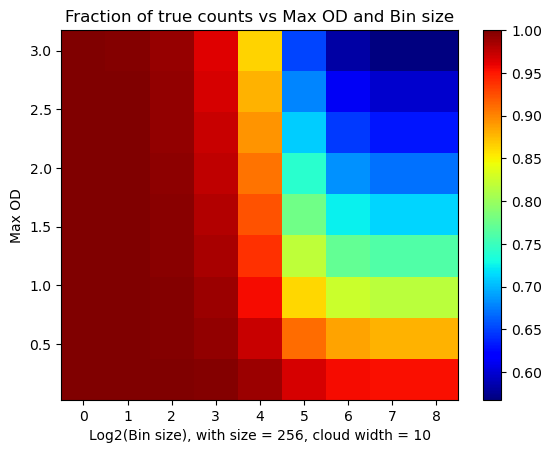

In [175]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.log2(big_pixel_size), max_OD, fraction_of_true_counts.T, cmap = 'jet', alpha = 1.0)
ax.set_xlabel(f'Log2(Bin size), with size = {size}, cloud width = 10')
ax.set_ylabel('Max OD')
ax.set_title('Fraction of true counts vs Max OD and Bin size')
plt.colorbar(im)
plt.show()

## <font size = 3>Given a box size, how robust is atom counting if the atomic sample is given TOF?</font>

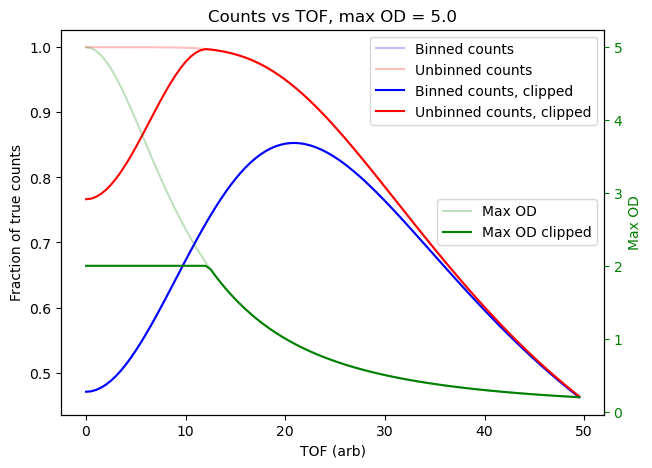

In [176]:
# Crop image such that we lose atoms if TOF exceeds a certain value. Then see how faithful the binned counts are wrt TOF
# also, to be more realistic, clip OD such that maxOD is some fixed value, like something >= 2
max_OD, OD_ceiling, size, width, light_level_woa, light_level_dark = 5.0, 2.0, 200, 10, 1000, 100
OD_wo_TOF = generate_atom_gaussian_OD(max_OD=max_OD, xsize=size,ysize=size,width_x=width,width_y=width)
ROI = np.index_exp[int(size/2)-int(size/4):int(size/2)+int(size/4), int(size/2)-int(size/4):int(size/2)+int(size/4) ]
true_counts = sum(sum(OD_wo_TOF))
TOF = np.arange(0,50,0.5)
without_atoms = generate_without_atom_light(xsize=size, ysize = size, light_level=light_level_woa)
dark = generate_dark_light(xsize=size, ysize = size, light_level=light_level_dark)
with_atoms = generate_with_atom_from_true_OD(without_atoms, OD_wo_TOF, dark)

# calculated cropped frames:
OD_wo_TOF_cropped = OD_wo_TOF[ROI]
without_atoms_cropped = without_atoms[ROI]
dark_cropped = dark[ROI]
cropped_size = OD_wo_TOF_cropped.shape[0]

TOF_counts_binned = np.array([])
TOF_counts_unbinned = np.array([])
TOF_counts_binned_clipped = np.array([])
TOF_counts_unbinned_clipped = np.array([])
max_OD_array = np.array([])
max_OD_array_clipped = np.array([])

for t in TOF:
    OD_w_TOF = np.array(gaussian_filter(OD_wo_TOF, sigma=t))
    OD_w_TOF_cropped = OD_w_TOF[ROI]
    with_atoms_cropped = generate_with_atom_from_true_OD(without_atoms_cropped, OD_w_TOF_cropped, dark_cropped)

    # calculate raw_counts from summing the absorption, then take -log:
    absorption_fraction = (with_atoms_cropped - dark_cropped) / (without_atoms_cropped - dark_cropped)
    
    average_absorption_fraction = sum(sum(absorption_fraction)) / (cropped_size * cropped_size) 
    binned_OD = -np.log( average_absorption_fraction ) * cropped_size * cropped_size
    unbinned_OD = sum(sum(-np.log(absorption_fraction)))
    binned_OD_clipped = min(-np.log( average_absorption_fraction ), OD_ceiling ) * cropped_size * cropped_size
    unbinned_OD_clipped = np.sum( np.clip(  -np.log(absorption_fraction) , a_min = 0, a_max = OD_ceiling ))
    # get counts
    TOF_counts_binned = np.append(TOF_counts_binned, binned_OD)
    TOF_counts_unbinned = np.append(TOF_counts_unbinned, unbinned_OD)
    TOF_counts_binned_clipped = np.append(TOF_counts_binned_clipped, binned_OD_clipped)
    TOF_counts_unbinned_clipped = np.append(TOF_counts_unbinned_clipped, unbinned_OD_clipped)
    # max OD data:
    max_OD_array = np.append(max_OD_array, np.max(OD_w_TOF))
    max_OD_array_clipped = np.append(max_OD_array_clipped, min(np.max(OD_w_TOF), OD_ceiling ))

fig, ax = plt.subplots(figsize = (7,5))
ax.set_title(f'Counts vs TOF, max OD = {max_OD}')
ax.plot(TOF, TOF_counts_binned/true_counts, color = 'blue', alpha = 0.25, label = 'Binned counts')
ax.plot(TOF, TOF_counts_unbinned/true_counts, color = 'red', alpha = 0.25, label = 'Unbinned counts')
ax.plot(TOF, TOF_counts_binned_clipped/true_counts, color = 'blue', label = 'Binned counts, clipped')
ax.plot(TOF, TOF_counts_unbinned_clipped/true_counts, color = 'red', label = 'Unbinned counts, clipped')
ax.set_xlabel('TOF (arb)')
ax.set_ylabel('Fraction of true counts')
# ax.axhline(y=true_counts, color = 'black', linestyle = '--')
ax.legend()

ax1 = ax.twinx()
ax1.plot(TOF, max_OD_array, color = 'green', alpha = 0.25, label = 'Max OD')
ax1.plot(TOF, max_OD_array_clipped, color = 'green', label = 'Max OD clipped')
ax1.set_ylabel('Max OD', color = 'green')
ax1.tick_params(axis='y', colors='green')
ax1.legend(loc = 'center right')

plt.show()


## <font size = 3>How does noise affect the unbinned count?</font>

In [178]:
max_OD, size, width, light_level_woa, light_level_dark = 1.3, 200, 10, 400, 100
true_OD = generate_atom_gaussian_OD(max_OD=max_OD, xsize=size,ysize=size,width_x=width,width_y=width)
true_counts = sum(sum(true_OD))

without_atoms = generate_without_atom_light(xsize=size, ysize = size, light_level=light_level_woa)
dark = generate_dark_light(xsize=size, ysize = size, light_level=light_level_dark)
with_atoms = generate_with_atom_from_true_OD(without_atoms, true_OD, dark)

iterations = 200
counts_with_noise = np.array([])

for i in range(iterations):
    without_atoms_with_noise = generate_shot_noise(without_atoms)
    dark_with_noise = generate_shot_noise(dark)
    with_atoms_with_noise = generate_shot_noise(with_atoms)

    OD_with_noise = -np.log(  (with_atoms_with_noise - dark_with_noise) / (without_atoms_with_noise - dark_with_noise))

    count_with_noise = sum(sum(OD_with_noise))
    counts_with_noise = np.append(counts_with_noise, count_with_noise)


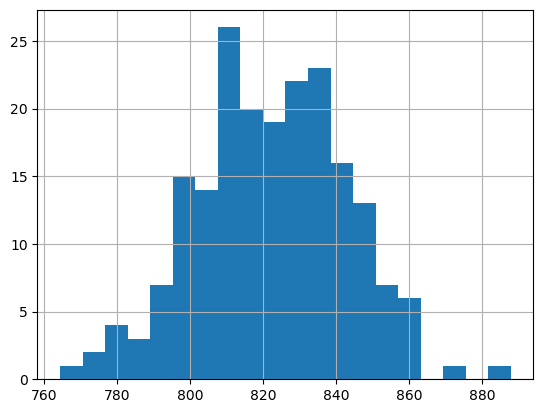

In [179]:
plt.hist(counts_with_noise, bins = 20)
plt.grid()

## <font size = 3>Imaging artifact 1: different light levels between with and without atom shots</font>

# <font size = 5>NaK Feshbach molecules</font>

## <font size = 3>Feshbach resonance landscape</font>

In [578]:
# generate FB resonance landscape for Na-Km72 and Na-Km92
def FB_resonance_landscape_Km92_Km72(B_interest):

    B = np.linspace(60,140,100000)
    
    # m72 FB resonances from Tiemann theory + updates
    m72_Bres_1 = 81.65 
    m72_Bres_2 = 90.40 
    m72_Bres_3 = 112.1964

    m72_B_zero_crossing_1 = m72_Bres_1 - 0.30
    m72_B_zero_crossing_2 = m72_Bres_2 - 6.50
    m72_B_zero_crossing_3 = m72_Bres_3 - 17.3923

    m72_B_resonances = np.array([m72_Bres_1, m72_Bres_2, m72_Bres_3])
    m72_B_zero_crossings = np.array([m72_B_zero_crossing_1, m72_B_zero_crossing_2, m72_B_zero_crossing_3])
    m72_B_width  = m72_B_resonances - m72_B_zero_crossings

    m72_a_bg = -710 

    # m92 FB resonances from Tiemann theory + updates  
    m92_Bres_1 = 78.35
    m92_Bres_2 = 89.80

    m92_B_zero_crossing_1 = m92_Bres_1 - 5.80
    m92_B_zero_crossing_2 = m92_Bres_2 - 9.55

    m92_B_resonances = np.array([m92_Bres_1, m92_Bres_2])
    m92_B_zero_crossings = np.array([m92_B_zero_crossing_1, m92_B_zero_crossing_2])
    m92_B_width  = m92_B_resonances - m92_B_zero_crossings

    m92_a_bg = -730 

    # calculate m72 scattering lengths:
    a_m72 = m72_a_bg
    for i in range(len(m72_B_resonances)):
        a_m72 *= (1 + m72_B_width[i] / (B - m72_B_resonances[i]) )

    # calculate m92 scattering lengths:
    a_m92 = m92_a_bg
    for i in range(len(m92_B_resonances)):
        a_m92 *= (1 + m92_B_width[i] / (B - m92_B_resonances[i]) )

    # generate data for B_interest:
    a_m72_interest = m72_a_bg
    a_m92_interest = m92_a_bg
    NaKm72_bound_state = False
    NaKm92_bound_state = False
    plot_B_interest = False
    if min(B) < B_interest < max(B):
        plot_B_interest = True
        for i in range(len(m72_B_resonances)):
            a_m72_interest *= (1 + m72_B_width[i] / (B_interest - m72_B_resonances[i]) )
        for i in range(len(m92_B_resonances)):
            a_m92_interest *= (1 + m92_B_width[i] / (B_interest - m92_B_resonances[i]) )
        
        NaKm72_bound_state = a_m72_interest > 0
        NaKm92_bound_state = a_m92_interest > 0

        if NaKm72_bound_state:
            print('Calculating bound state energy...')
        if NaKm92_bound_state:
            print('Calculating bound state energy...')

        # print stuff
        print('------------ RESULTS ------------------')
        print(f'Magnetic field of interest: {B_interest} G')
        print(f'Na-Km72 scattering length:  {a_m72_interest:.2f} a0')
        print(f'Na-Km92 scattering length:  {a_m92_interest:.2f} a0')
        print(NaKm72_bound_state)
        print(NaKm92_bound_state)
        print('-------------- END --------------------')
    else:
        print('Magnetic field of interest OUT OF RANGE!')
    
    # plot:
    fig, ax = plt.subplots(figsize = (6.6,4.5))
    if plot_B_interest:
        ax.axvline(x=B_interest, linestyle = '--', color = 'green')
    ax.plot(B,a_m72, color = 'blue')
    ax.plot(B,a_m92, color = 'red')
    ax.set_ylim([-4000,4000])
    ax.grid()
    ax.set_title('Scattering length for Na and K $m_F = -7/2$ and $m_F = -9/2$')
    ax.set_xlabel('Magnetic field (G)')
    ax.set_ylabel('Scattering length ($a_0$)')
    plt.tight_layout()
    plt.show()

    return 

Calculating bound state energy...
------------ RESULTS ------------------
Magnetic field of interest: 101.0 G
Na-Km72 scattering length:  643.66 a0
Na-Km92 scattering length:  -1698.78 a0
True
False
-------------- END --------------------


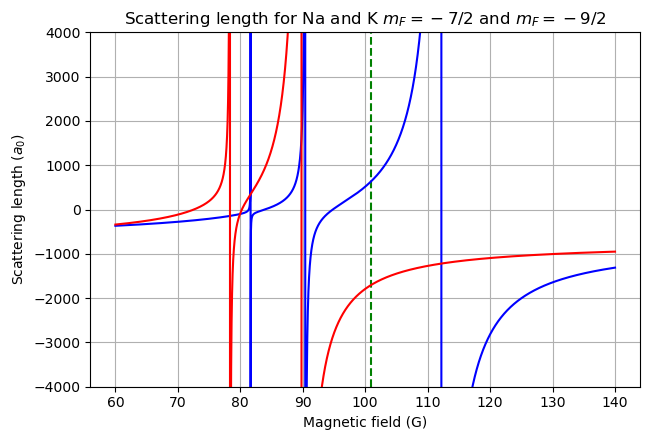

In [579]:
FB_resonance_landscape_Km92_Km72(B_interest = 101.00)

## <font size = 3>Binding energy vs magnetic field</font>

In [522]:
# plot binding energy vs magnetic field (naive model)
# a more precise 1-parameter model is given by Eqn (2) of CHW's paper
def Eb(B, width_FB = [5.8, 9.55],B_FB = [78.35, 89.8]):
    a_mean = 51*a0
    a_bg = -690 * a0
    fb_factor = 1
    for i in range(len(B_FB)):
        fb_factor *= (1+width_FB[i]/(B-B_FB[i]))
    a = a_bg*fb_factor
    Eb = hbar**2 / (2*muNa40K*u*(a - a_mean)**2)
    return Eb/(hbar*2*np.pi)

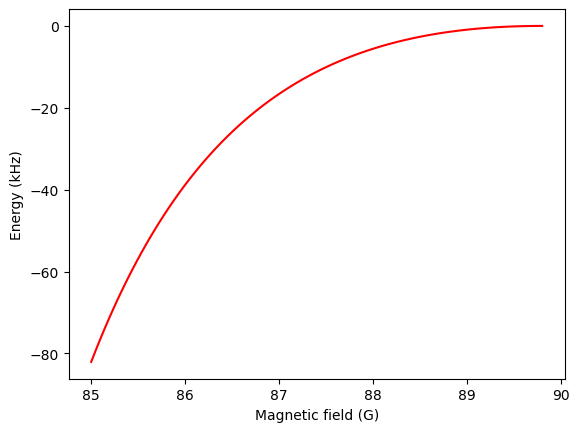

In [523]:
B = np.linspace(85.0,89.8,100)
Eb_array = Eb(B)
plt.plot(B,-Eb_array*1e-3, color='red')
plt.xlabel('Magnetic field (G)')
plt.ylabel('Energy (kHz)')
plt.show()

# <font size = 5>Trap frequency measurement, FFT analysis</font>

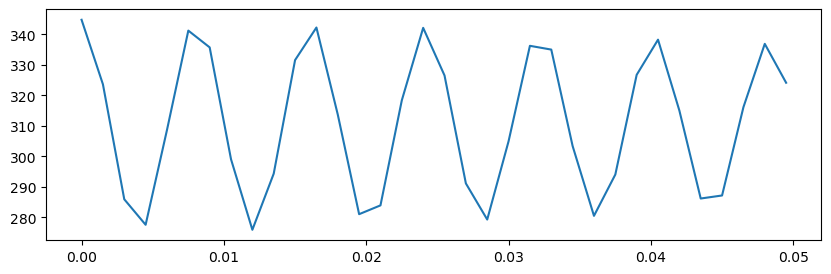

In [413]:
# test FFT
f1 = 125 # Hz
f2 = 118 # Hz
spacing = 1.5e-3
theta = 10*np.pi/180 # mixing angle in radians
t = np.arange(0e-3,50e-3,spacing)
N = t.shape[0]
y = 30*(np.cos(theta) * np.cos(f1 * 2.0*np.pi * t) + np.sin(theta) * np.cos(f2 * 2.0*np.pi * t)) + 310
fig, ax = plt.subplots(figsize = (10,3))
ax.plot(t,y)
fig.show()

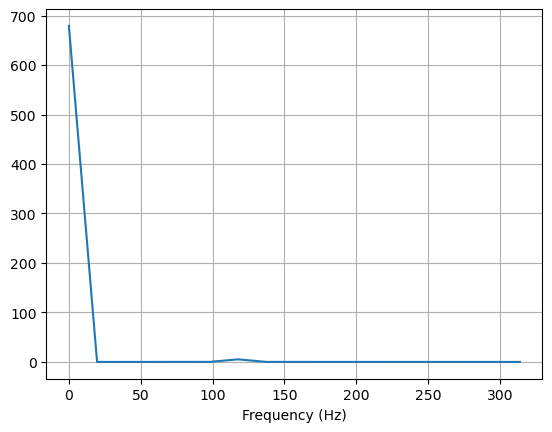

In [412]:
from scipy.fft import fft, fftfreq
yf = fft(y)
tf = fftfreq(N, spacing)[:N//2]
plt.plot(tf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel('Frequency (Hz)')
# plt.ylim([0,50])
# plt.xlim([112,136])
plt.grid()
plt.show()

In [68]:
with open('/Users/huanbui/Downloads/dataframe_20231128T162329_BENCHMARK_ODT_YCAM_freq_measurement.pkl', 'rb') as f:
    data = pickle.load(f)

In [79]:
xdata = data['T_HOLD_AFTER_SHAKE']
ydata = data['ycam_analysis_python']['Center x']

sort_mask = np.argsort(xdata)
xdata_sorted = np.array(xdata[sort_mask])
ydata_sorted = np.array(ydata[sort_mask])

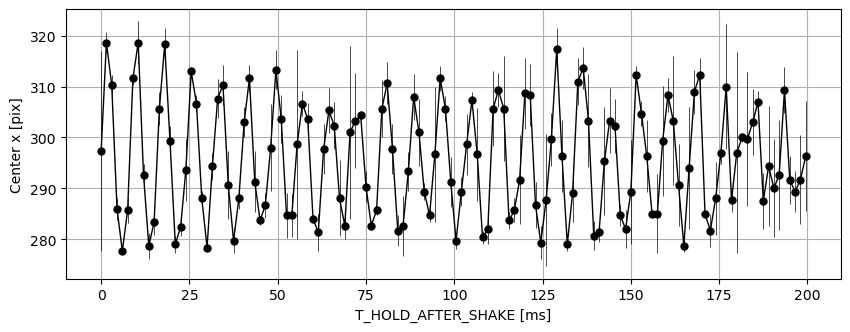

In [133]:
new_xdata, new_ydata, ydata_stdevs  = raw_to_averages_and_stdev(xdata_sorted, ydata_sorted)
numpoints = new_xdata.shape[0]
spacing = abs(new_xdata[0] - new_xdata[1])

fig, ax = plt.subplots(figsize = (10,3.5))
ax.errorbar(new_xdata*1e3, new_ydata, yerr = ydata_stdevs, fmt = 'o-', color = 'black', markersize = 5, elinewidth = 0.5, linewidth = 1.0)
ax.set_xlabel('T_HOLD_AFTER_SHAKE [ms]')
ax.set_ylabel('Center x [pix]')
plt.grid()

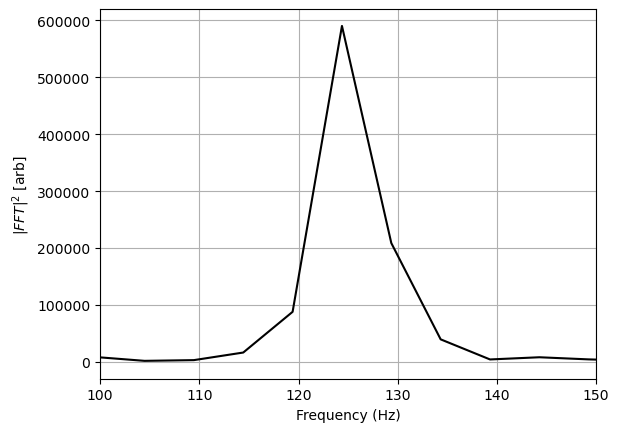

In [151]:
yf = fft(new_ydata - np.mean(new_ydata))
tf = fftfreq(numpoints, spacing)[:numpoints//2]
plt.plot(tf, np.abs(yf[0:numpoints//2])**2, color = 'black')
plt.xlabel('Frequency (Hz)')
# plt.ylim([0,12])
plt.xlim([100,150])
plt.ylabel('$|FFT|^2$ [arb]')
plt.grid()
plt.show()

# <font size = 5>Thermometry analysis</font>

In [386]:
def Gaussian_2D(x, y,amplitude, x0,y0,sigma_x,sigma_y,offset):
    g = np.zeros((y.shape[0], x.shape[0]))
    for ix in range(len(x)):
        for iy in range(len(y)):
            g[iy][ix] = offset + amplitude*np.exp(-(x[ix] - x0)**2/(2*sigma_x**2))*np.exp(-(y[iy] - y0)**2/(2*sigma_y**2))
    return g

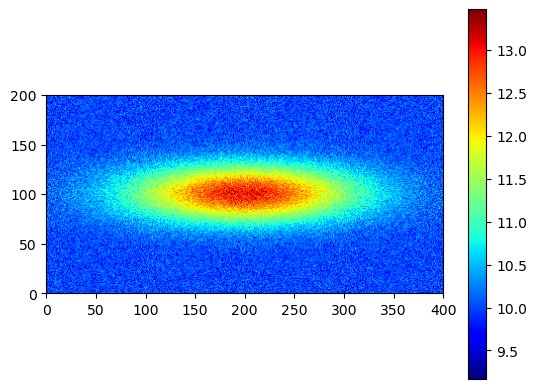

In [387]:
x = np.linspace(0, 400, 401)
y = np.linspace(0, 200, 201)
data = Gaussian_2D(x, y, 3, 200,100,80,20,10)
data_noisy = data + 0.2*np.random.normal(size=data.shape)
plt.imshow(data_noisy, origin='lower', cmap='jet',extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
plt.show()

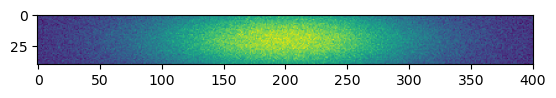

In [371]:
plt.imshow(data_noisy[80:120,:])

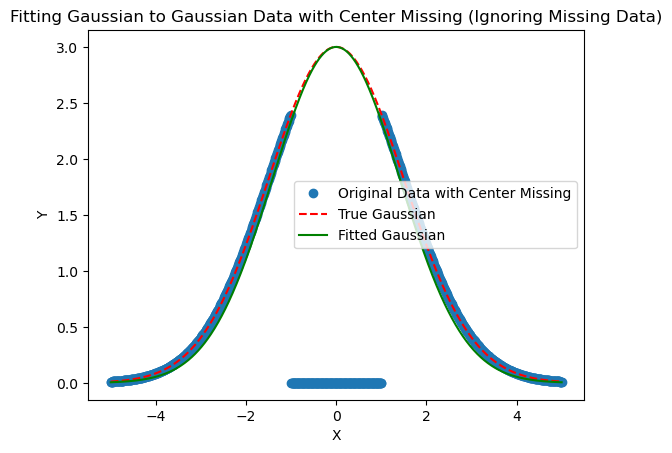

Amplitude: 2.999983299996415
Mean: 0.0
Standard Deviation: 1.0


In [399]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

# Generate example Gaussian data
np.random.seed(42)
data_size = 1000
x_data = np.linspace(-5, 5, data_size)
y_true = 3 * np.exp(-0.5 * ((x_data - 0) / 1.5)**2)

# Remove the center portion
center_exclude = (x_data > -1) & (x_data < 1)
y_data = y_true.copy()
y_data[center_exclude] = 0

# Define the custom loss function
def custom_loss(params, x, y):
    amplitude, mean, stddev = params
    y_pred = gaussian(x, amplitude, mean, stddev)
    loss = np.sum((y_pred[~center_exclude] - y[~center_exclude])**2)
    return loss

# Fit the Gaussian to the data, ignoring the missing center portion
initial_guess = [max(y_true), 0, 1]  # Initial guess for amplitude, mean, and standard deviation
params, _ = curve_fit(lambda x, amplitude, mean, stddev: custom_loss([amplitude, mean, stddev], x, y_data), x_data, y_data, p0=initial_guess)

# Plot the original Gaussian data and the fitted Gaussian
plt.plot(x_data, y_data, label='Original Data with Center Missing', marker='o', linestyle='None')
plt.plot(x_data, y_true, 'r--', label='True Gaussian')
plt.plot(x_data, gaussian(x_data, *params), 'g-', label='Fitted Gaussian')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting Gaussian to Gaussian Data with Center Missing (Ignoring Missing Data)')
plt.show()

# Print the parameters of the fitted Gaussian
print(f'Amplitude: {params[0]}')
print(f'Mean: {params[1]}')
print(f'Standard Deviation: {params[2]}')

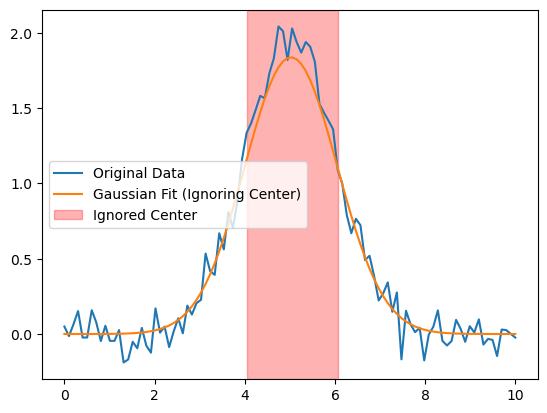

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

# Generate example data
np.random.seed(42)
x_data = np.linspace(0, 10, 100)
y_data = 2 * np.exp(-(x_data - 5)**2 / 2) + np.random.normal(0, 0.1, size=len(x_data))

# Function to fit the data, ignoring the center portion
def fit_gaussian_ignore_center(x, y, ignore_center_percent=0.2):
    # Determine the range of indices to ignore in the center
    center_start = int((1 - ignore_center_percent) / 2 * len(x))
    center_end = int((1 + ignore_center_percent) / 2 * len(x))

    # Exclude the center portion
    x_fit = np.concatenate([x[:center_start], x[center_end:]])
    y_fit = np.concatenate([y[:center_start], y[center_end:]])

    # Perform the curve fit
    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[1, np.mean(x_fit), 1])

    return popt, pcov

# Ignore the center 20% of the data
params, covariance = fit_gaussian_ignore_center(x_data, y_data, ignore_center_percent=0.2)

# Generate the fitted curve
y_fit = gaussian(x_data, *params)

# Plot the original data, the ignored center portion, and the fitted curve
plt.plot(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, label='Gaussian Fit (Ignoring Center)')
plt.axvspan(x_data[int((1 - 0.2) / 2 * len(x_data))], x_data[int((1 + 0.2) / 2 * len(x_data))], color='red', alpha=0.3, label='Ignored Center')
plt.legend()
plt.show()